## Analyze Earthquakes
The National Earthquake Information Center (NEIC) determines the location and size of all significant earthquakes that occur worldwide and disseminates this information immediately to national and international agencies, scientists, critical facilities, and the general public. The NEIC compiles and provides to scientists and to the public an extensive seismic database that serves as a foundation for scientific research through the operation of modern digital national and global seismograph networks and cooperative international agreements. The NEIC is the national data center and archive for earthquake information.
This dataset includes a record of the date, time, location, depth, magnitude, and source of every earthquake with a reported magnitude 5.5 or higher since 1965.
Conduct an EDA on the dataset and try to uncover meaningful and/or interesting insights from the dataset.

### A. INITIAL PROCESSING

In [2]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline

import os
os.environ["PROJ_LIB"] = "C:\\Users\\rayde\\anaconda3\\Library\\share";
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt
import datetime
from matplotlib import dates as mpl_dates
import seaborn as sns

ModuleNotFoundError: No module named 'Basemap'

In [42]:
#matplotlib.style.use('ggplot')
plt.style.use('seaborn-whitegrid')

In [43]:
# Read the dataset and then view the top few records and the summary of the data
quakeData = pd.read_csv("earthquake.csv", parse_dates=[[0, 1]], infer_datetime_format=True) 
print (quakeData.head())

             Date_Time  Latitude  Longitude        Type  Depth  Depth Error  \
0  01/02/1965 13:44:18    19.246    145.616  Earthquake  131.6          NaN   
1  01/04/1965 11:29:49     1.863    127.352  Earthquake   80.0          NaN   
2  01/05/1965 18:05:58   -20.579   -173.972  Earthquake   20.0          NaN   
3  01/08/1965 18:49:43   -59.076    -23.557  Earthquake   15.0          NaN   
4  01/09/1965 13:32:50    11.938    126.427  Earthquake   15.0          NaN   

   Depth Seismic Stations  Magnitude Magnitude Type  Magnitude Error  \
0                     NaN        6.0             MW              NaN   
1                     NaN        5.8             MW              NaN   
2                     NaN        6.2             MW              NaN   
3                     NaN        5.8             MW              NaN   
4                     NaN        5.8             MW              NaN   

   Magnitude Seismic Stations  Azimuthal Gap  Horizontal Distance  \
0                      

### B. TREATMENT OF INCORRECT DATE TIME FORMAT

In [44]:
# Now there are some date time occurrences which are not matching the expected format
print (quakeData['Date_Time'].sort_values().tail())

22496                                  12/31/2014 09:26:22
22942                                  12/31/2015 10:56:58
3378     1975-02-23T02:58:41.000Z 1975-02-23T02:58:41.000Z
7512     1985-04-28T02:53:41.530Z 1985-04-28T02:53:41.530Z
20650    2011-03-13T02:23:34.520Z 2011-03-13T02:23:34.520Z
Name: Date_Time, dtype: object


In [45]:
# As evident from the above data there are three observations where the date time format is incorrect. Let us fix the same.
f = lambda x: datetime.datetime(year = int(x[0:4]), month = int(x[5:7]), day = int(x[8:10]), 
                                hour = int(x[11:13]), minute = int(x[14:16]), second = int(x[17:19])) if len(x) > 19 else x
quakeData['Date_Time'] = quakeData['Date_Time'].apply(f)

In [46]:
# Considering the Date_Time column still has the datatype as object; let us try to change this to datetime format.
quakeData['Date_Time'] = pd.to_datetime(quakeData['Date_Time'])

In [47]:
# Setting the index for the dataframe as the date time of the recorded earthquake
quakeData.set_index('Date_Time', inplace= True)
print (quakeData.index)

DatetimeIndex(['1965-01-02 13:44:18', '1965-01-04 11:29:49',
               '1965-01-05 18:05:58', '1965-01-08 18:49:43',
               '1965-01-09 13:32:50', '1965-01-10 13:36:32',
               '1965-01-12 13:32:25', '1965-01-15 23:17:42',
               '1965-01-16 11:32:37', '1965-01-17 10:43:17',
               ...
               '2016-12-24 03:58:55', '2016-12-25 14:22:27',
               '2016-12-25 14:32:13', '2016-12-27 23:20:56',
               '2016-12-28 08:18:01', '2016-12-28 08:22:12',
               '2016-12-28 09:13:47', '2016-12-28 12:38:51',
               '2016-12-29 22:30:19', '2016-12-30 20:08:28'],
              dtype='datetime64[ns]', name='Date_Time', length=23412, freq=None)


In [48]:
print (quakeData.describe())

           Latitude     Longitude         Depth  Depth Error  \
count  23412.000000  23412.000000  23412.000000  4461.000000   
mean       1.679033     39.639961     70.767911     4.993115   
std       30.113183    125.511959    122.651898     4.875184   
min      -77.080000   -179.997000     -1.100000     0.000000   
25%      -18.653000    -76.349750     14.522500     1.800000   
50%       -3.568500    103.982000     33.000000     3.500000   
75%       26.190750    145.026250     54.000000     6.300000   
max       86.005000    179.998000    700.000000    91.295000   

       Depth Seismic Stations     Magnitude  Magnitude Error  \
count             7097.000000  23412.000000       327.000000   
mean               275.364098      5.882531         0.071820   
std                162.141631      0.423066         0.051466   
min                  0.000000      5.500000         0.000000   
25%                146.000000      5.600000         0.046000   
50%                255.000000      5.70

### C. TREATMENT OF MISSING VALUES

In [49]:
# For treating the missing values in the Depth Error and Depth Seismic Stations, 
#   we are first going to create different bins as per the depth of the earthquake
#   next, for the rows with the missing values, we use the corresponding median depth error and depth seismic stations for the corresponding bin

# The assumption is that the depth error and depth seismic stations are directly correlated to the depth of the earthquake
binsDepth = np.arange(-100, 800, 25)
quakeData['Depth_bins'] = pd.cut(x = quakeData['Depth'], bins = binsDepth)
print (quakeData.head(2))

                     Latitude  Longitude        Type  Depth  Depth Error  \
Date_Time                                                                  
1965-01-02 13:44:18    19.246    145.616  Earthquake  131.6          NaN   
1965-01-04 11:29:49     1.863    127.352  Earthquake   80.0          NaN   

                     Depth Seismic Stations  Magnitude Magnitude Type  \
Date_Time                                                               
1965-01-02 13:44:18                     NaN        6.0             MW   
1965-01-04 11:29:49                     NaN        5.8             MW   

                     Magnitude Error  Magnitude Seismic Stations  \
Date_Time                                                          
1965-01-02 13:44:18              NaN                         NaN   
1965-01-04 11:29:49              NaN                         NaN   

                     Azimuthal Gap  Horizontal Distance  Horizontal Error  \
Date_Time                                           

In [50]:
# Now based on the depth bin identified in previous step let us use the median of the depth bin to fill the missing values
quakeData["Depth Error"] = quakeData["Depth Error"].fillna(quakeData.groupby('Depth_bins')['Depth Error'].transform('median'))
quakeData["Depth Seismic Stations"] = quakeData["Depth Seismic Stations"].fillna(quakeData.groupby('Depth_bins')['Depth Seismic Stations'].transform('median'))
print (quakeData.describe())

           Latitude     Longitude         Depth   Depth Error  \
count  23412.000000  23412.000000  23412.000000  23412.000000   
mean       1.679033     39.639961     70.767911      3.743568   
std       30.113183    125.511959    122.651898      2.455755   
min      -77.080000   -179.997000     -1.100000      0.000000   
25%      -18.653000    -76.349750     14.522500      2.000000   
50%       -3.568500    103.982000     33.000000      3.750000   
75%       26.190750    145.026250     54.000000      4.550000   
max       86.005000    179.998000    700.000000     91.295000   

       Depth Seismic Stations     Magnitude  Magnitude Error  \
count            23412.000000  23412.000000       327.000000   
mean               261.462946      5.882531         0.071820   
std                 98.111923      0.423066         0.051466   
min                  0.000000      5.500000         0.000000   
25%                234.000000      5.600000         0.046000   
50%                237.000000 

In [51]:
# Similarly, for treating the missing values in the Magnitude Error and Magnitude Seismic Stations, 
#   we are first going to create different bins as per the magnitude of the earthquake
#   next, for the rows with the missing values, we use the median magnitude error for the corresponding bin

# The assumption is that the magnitude error is directly correlated to the magnitude of the earthquake
binsMagnitude = np.arange(5.25,9.50,0.25)
quakeData['Magnitude_bins'] = pd.cut(x = quakeData['Magnitude'], bins = binsMagnitude)
quakeData['Magnitude Error'] = quakeData['Magnitude Error'].fillna(quakeData.groupby('Magnitude_bins')['Magnitude Error'].transform('median'))
quakeData['Magnitude Seismic Stations'] = quakeData['Magnitude Seismic Stations'].fillna(quakeData.groupby('Magnitude_bins')['Magnitude Seismic Stations'].transform('median'))
print (quakeData.describe())

           Latitude     Longitude         Depth   Depth Error  \
count  23412.000000  23412.000000  23412.000000  23412.000000   
mean       1.679033     39.639961     70.767911      3.743568   
std       30.113183    125.511959    122.651898      2.455755   
min      -77.080000   -179.997000     -1.100000      0.000000   
25%      -18.653000    -76.349750     14.522500      2.000000   
50%       -3.568500    103.982000     33.000000      3.750000   
75%       26.190750    145.026250     54.000000      4.550000   
max       86.005000    179.998000    700.000000     91.295000   

       Depth Seismic Stations     Magnitude  Magnitude Error  \
count            23412.000000  23412.000000     22164.000000   
mean               261.462946      5.882531         0.067415   
std                 98.111923      0.423066         0.028347   
min                  0.000000      5.500000         0.000000   
25%                234.000000      5.600000         0.052000   
50%                237.000000 

In [52]:
# Considering there are still few NA values for Magnitude Error and Magnitude Seismic Stations, let us fill them with the overall median
quakeData['Magnitude Error'] = quakeData['Magnitude Error'].fillna(quakeData['Magnitude Error'].median())
quakeData['Magnitude Seismic Stations'] = quakeData['Magnitude Seismic Stations'].fillna(quakeData['Magnitude Seismic Stations'].median())
print (quakeData.describe())

           Latitude     Longitude         Depth   Depth Error  \
count  23412.000000  23412.000000  23412.000000  23412.000000   
mean       1.679033     39.639961     70.767911      3.743568   
std       30.113183    125.511959    122.651898      2.455755   
min      -77.080000   -179.997000     -1.100000      0.000000   
25%      -18.653000    -76.349750     14.522500      2.000000   
50%       -3.568500    103.982000     33.000000      3.750000   
75%       26.190750    145.026250     54.000000      4.550000   
max       86.005000    179.998000    700.000000     91.295000   

       Depth Seismic Stations     Magnitude  Magnitude Error  \
count            23412.000000  23412.000000     23412.000000   
mean               261.462946      5.882531         0.066993   
std                 98.111923      0.423066         0.027639   
min                  0.000000      5.500000         0.000000   
25%                234.000000      5.600000         0.052000   
50%                237.000000 

### D. UNIVARIATE ANALYSIS - DEPTH

Now, let us plot a histogram of the Depth to understand if there are specific depths where most of the earthquakes occur.

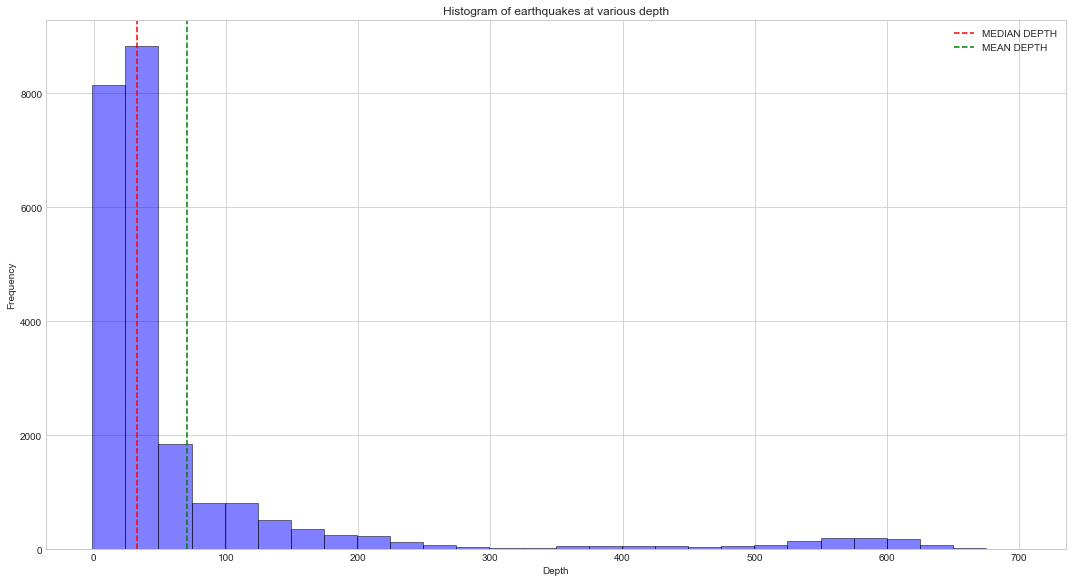

In [53]:
figure = plt.figure(figsize=(15,8))
plt.hist(quakeData['Depth'], color = 'blue', bins=28, alpha = 0.5, edgecolor = "black")
plt.axvline(x=np.median(quakeData['Depth']), color = 'r', linestyle = 'dashed', label= 'MEDIAN DEPTH')
plt.axvline(x=np.mean(quakeData['Depth']), color = 'g', linestyle = 'dashed', label= 'MEAN DEPTH')
plt.xlabel("Depth")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.title("Histogram of earthquakes at various depth")
plt.show()

Considering the huge difference in the frequency at lower depths to higher depths, the data for the higher depths are almost not visible. Hence, let us use logarithmic translation to even out the data a bit and hep us understand it better.

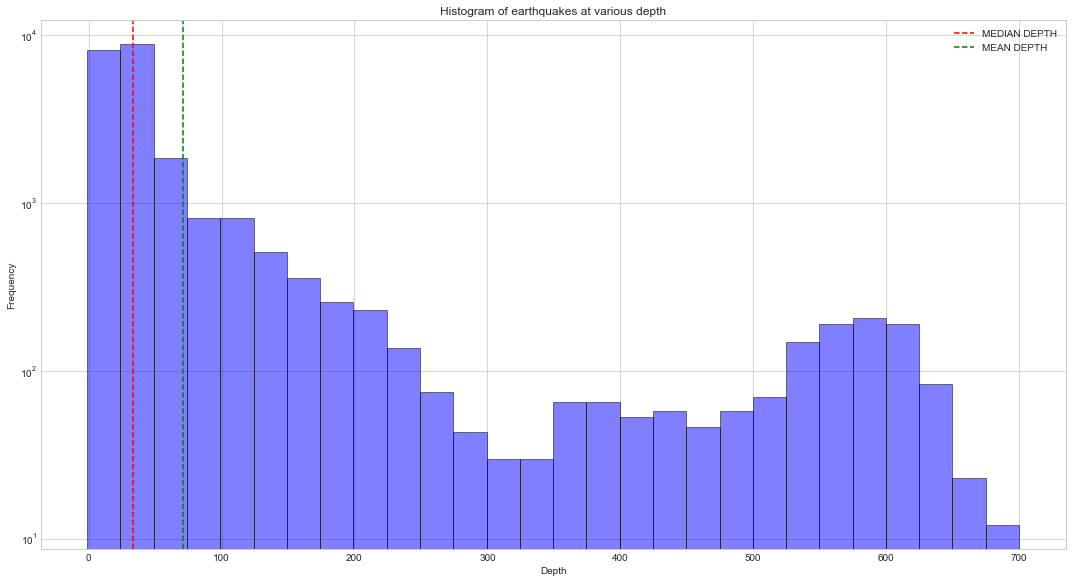

In [54]:
figure = plt.figure(figsize=(15,8))
plt.hist(quakeData['Depth'], color = 'blue', bins=28, alpha = 0.5, edgecolor = "black", log=True)
plt.axvline(x=np.median(quakeData['Depth']), color = 'r', linestyle = 'dashed', label= 'MEDIAN DEPTH')
plt.axvline(x=np.mean(quakeData['Depth']), color = 'g', linestyle = 'dashed', label= 'MEAN DEPTH')
plt.xlabel("Depth")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.title("Histogram of earthquakes at various depth")
plt.show()

Now, Let us try to plot a box plot to see this same data.

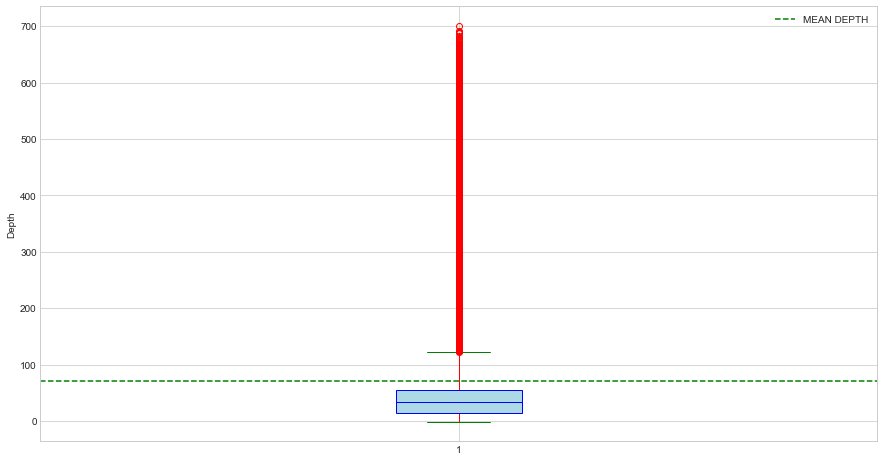

In [55]:
figure = plt.figure(figsize=(15,8))
plt.boxplot(quakeData['Depth'], 
            patch_artist=True, whis = 1.75,
            boxprops=dict(facecolor='lightblue', color='b'),
            capprops=dict(color='g'),
            whiskerprops=dict(color='r'),
            flierprops=dict(color='r', markeredgecolor='r'),
            medianprops=dict(color='b'))
plt.axhline(y = np.mean(quakeData['Depth']), color = 'g', linestyle='dashed', label='MEAN DEPTH')
plt.legend()
plt.ylabel('Depth')
plt.show()

#### INFERENCE OF UNIVARIATE ANALYSIS - DEPTH

As evident from the above histograms, 
1. Most of the earthquakes recorded happen at a depth of 25 to 50 units followed by 0 to 25 units range.
2. There is a gradual decrease of the number of earthquakes as the depth increases from 50 to 350.
3. There is an increase in count of earthquakes from 360 to 620 units.

In [56]:
print ("INFERENCE OF UNIVARIATE ANALYSIS - DEPTH")
print ("----------------------------------------")
print ("")
print ("As evident from the above histograms,")
print ("\t 1. Most of the earthquakes recorded happen at a depth of 25 to 50 units followed by 0 to 25 units range.")
print ("\t 2. There is a gradual decrease of the number of earthquakes as the depth increases from 50 to 350.")
print ("\t 3. There is an increase in count of earthquakes from 360 to 620 units.")

INFERENCE OF UNIVARIATE ANALYSIS - DEPTH
----------------------------------------

As evident from the above histograms,
	 1. Most of the earthquakes recorded happen at a depth of 25 to 50 units followed by 0 to 25 units range.
	 2. There is a gradual decrease of the number of earthquakes as the depth increases from 50 to 350.
	 3. There is an increase in count of earthquakes from 360 to 620 units.


### E. UNIVARIATE ANALYSIS - MAGNITUDE

Now, let us plot a histogram of the Magnitude to understand how severe most of the earthquakes are.

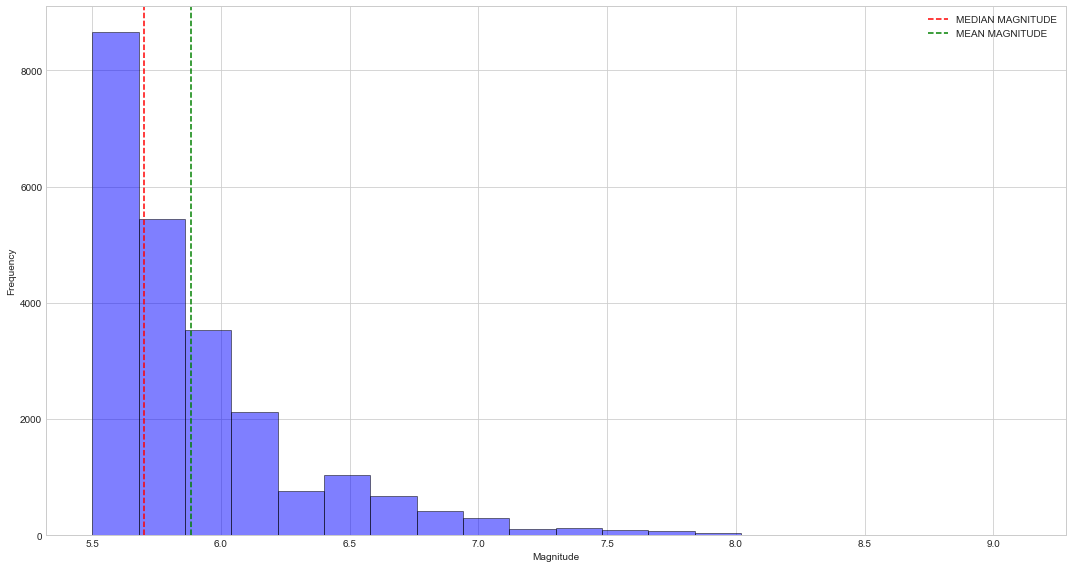

In [57]:
figure = plt.figure(figsize=(15,8))
plt.hist(quakeData['Magnitude'], color = 'blue', bins = 20, alpha = 0.5, edgecolor = "black")
plt.axvline(x=np.median(quakeData['Magnitude']), color = 'r', linestyle='dashed', label= 'MEDIAN MAGNITUDE')
plt.axvline(x=np.mean(quakeData['Magnitude']), color = 'g', linestyle='dashed', label= 'MEAN MAGNITUDE')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

Considering the huge difference in the frequency at lower magnitudes to higher magnitudes, the data for the higher magnitudes are almost not visible. Hence, let us use logarithmic translation to even out the data a bit and hep us understand it better.

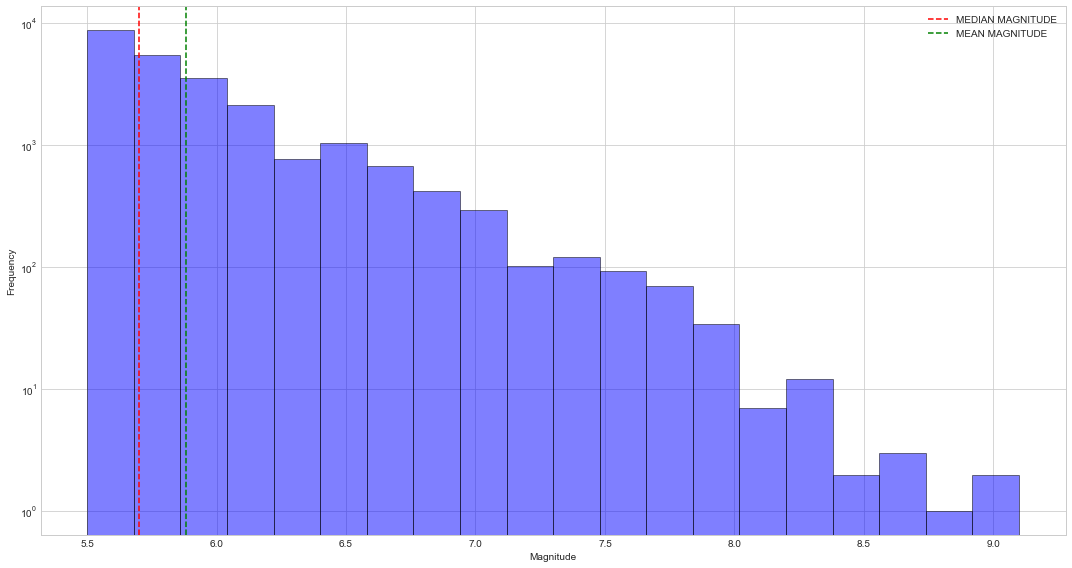

In [58]:
figure = plt.figure(figsize=(15,8))
plt.hist(quakeData['Magnitude'], color = 'blue', bins = 20, alpha = 0.5, edgecolor = "black", log = True)
plt.axvline(x=np.median(quakeData['Magnitude']), color = 'r', linestyle='dashed', label= 'MEDIAN MAGNITUDE')
plt.axvline(x=np.mean(quakeData['Magnitude']), color = 'g', linestyle='dashed', label= 'MEAN MAGNITUDE')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

Let us try to plot a box plot to see this same data.

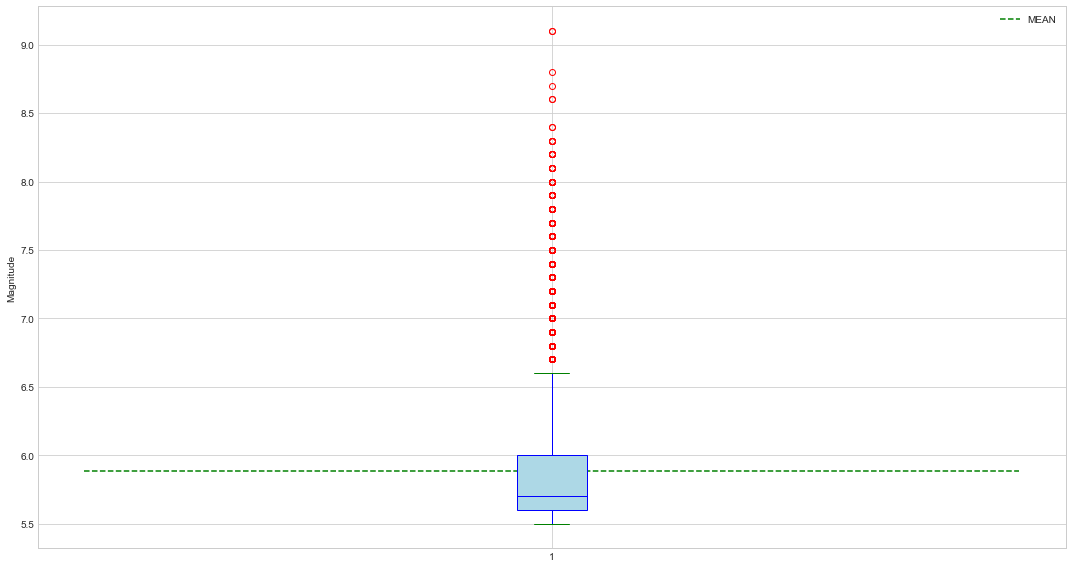

In [59]:
figure = plt.figure(figsize=(15,8))
plt.boxplot(quakeData['Magnitude'], 
            patch_artist=True, meanline = True, 
            boxprops=dict(facecolor='lightblue', color='b'),
            capprops=dict(color='g'),
            whiskerprops=dict(color='b'),
            flierprops=dict(color='r', markeredgecolor='r'),
            medianprops=dict(color='b'))
plt.hlines(y = np.mean(quakeData['Magnitude']), xmin= 0, xmax = 2, color = 'g', linestyles='dashed', label='MEAN')
plt.legend()
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

#### INFERENCE OF UNIVARIATE ANALYSIS - MAGNITUDE

As evident from the above histogram, 
1. Most of the earthquakes recorded are of magnitude between 5.5 to 5.75. 
2. Higher magnitude earthquakes are very less probable to occur and there is a gradual decrease of count with respect to increase in magnitude. This was evident from the histogram with the logarithmic translation of the data.  

In [60]:
print ("INFERENCE OF UNIVARIATE ANALYSIS - MAGNITUDE")
print ("--------------------------------------------")
print ("")
print ("As evident from the above histograms,")
print ("\t 1. Most of the earthquakes recorded are of magnitude between 5.5 to 5.75.")
print ("\t 2. Higher magnitude earthquakes are very less probable to occur and there is a gradual decrease of count with respect to increase in magnitude. This was evident from the histogram with the logarithmic translation of the data.")

INFERENCE OF UNIVARIATE ANALYSIS - MAGNITUDE
--------------------------------------------

As evident from the above histograms,
	 1. Most of the earthquakes recorded are of magnitude between 5.5 to 5.75.
	 2. Higher magnitude earthquakes are very less probable to occur and there is a gradual decrease of count with respect to increase in magnitude. This was evident from the histogram with the logarithmic translation of the data.


### F. UNIVARIATE ANALYSIS - DATE OF EARTHQUAKES

##### Let us try to now analyze how many earthquakes that have took place on monthly basis and their minimum and maximum magnitude, to help us uncover any pattern.

In [61]:
# Get the data grouped on mnthly basis
monthlyData = quakeData.groupby(quakeData.index.to_period('M'))["Magnitude"].agg({np.size, min,max})
print (monthlyData.head())

           max  min  size
Date_Time                
1965-01    8.2  5.5  13.0
1965-02    8.7  5.6  54.0
1965-03    7.6  5.5  38.0
1965-04    6.7  5.6  33.0
1965-05    7.7  5.5  22.0


In [62]:
# Create a separate list of the month and year to plot on the x axis
monthYear = monthlyData.index.strftime("%Y-%m").tolist()
# Considering the space constraint, we will plot the x-ticks for every 5 years.
xlabels = []
for i in np.arange(0,monthlyData.shape[0],30):
    xlabels.append(monthYear[i])

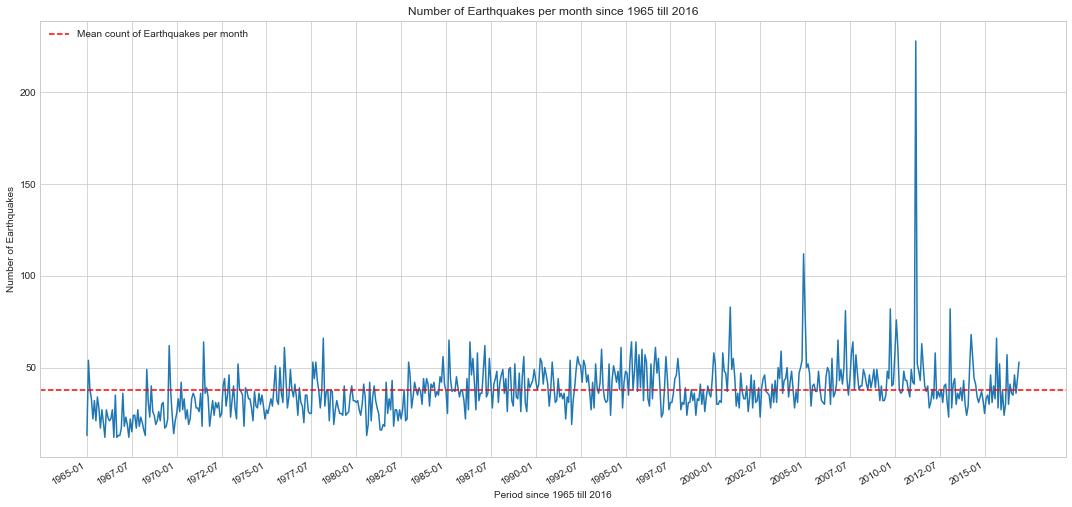

In [63]:
# Plot the line graph for the number of earthquakes per month
figure = plt.figure(figsize=(15,8))
plt.plot(monthYear, monthlyData["size"])
plt.xlabel("Period since 1965 till 2016")
plt.ylabel("Number of Earthquakes")
plt.xticks(ticks = np.arange(0,monthlyData.shape[0],30), labels = xlabels)
plt.grid(b=True, which='major', axis='both')
plt.title("Number of Earthquakes per month since 1965 till 2016")
plt.tight_layout()
plt.axhline(y = np.mean(monthlyData["size"]), linestyle="dashed", 
           color="red",label="Mean count of Earthquakes per month")
plt.legend()
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

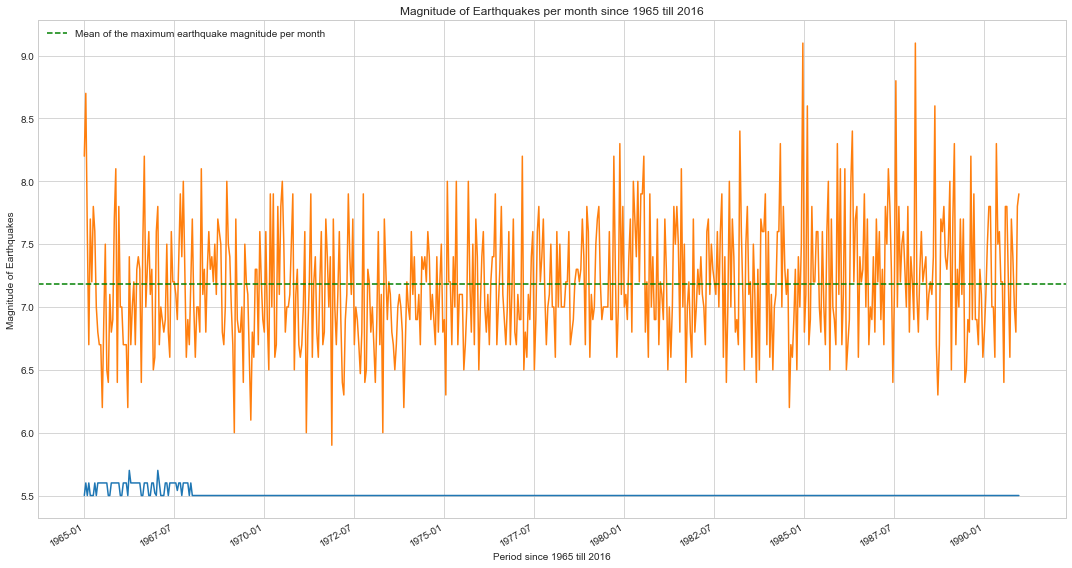

In [64]:
# Plot the line graph for the minimum and maximum magnitude per month
figure = plt.figure(figsize=(15,8))
plt.plot(monthYear, monthlyData["min"])
plt.plot(monthYear, monthlyData["max"])
plt.xlabel("Period since 1965 till 2016")
plt.ylabel("Magnitude of Earthquakes")
plt.xticks(ticks = np.arange(0,monthlyData.shape[0],60), labels = xlabels)
plt.grid(b=True, which='major', axis='both')
plt.axhline(y = np.mean(monthlyData["max"]),linestyle="dashed", 
           color="green",label="Mean of the maximum earthquake magnitude per month")
plt.title("Magnitude of Earthquakes per month since 1965 till 2016")
plt.legend(loc = "upper left")
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

##### Considering monthly analysis has too many data points and decoding any underlying pattern is difficult, let us aggregate at annual basis.

In [65]:
# Get the data grouped on mnthly basis
annualData = quakeData.groupby(quakeData.index.to_period('A'))["Magnitude"].agg({np.size, min,max})
print (annualData.head())

           max  min   size
Date_Time                 
1965       8.7  5.5  339.0
1966       8.1  5.5  234.0
1967       7.4  5.5  255.0
1968       8.2  5.5  305.0
1969       7.8  5.5  323.0


In [66]:
# Create a separate list of the month and year to plot on the x axis
Year = annualData.index.strftime("%Y").tolist()
# Considering the space constraint, we will plot the x-ticks for every 2 years.
xlabels = []
for i in np.arange(0,annualData.shape[0],2):
    xlabels.append(Year[i])

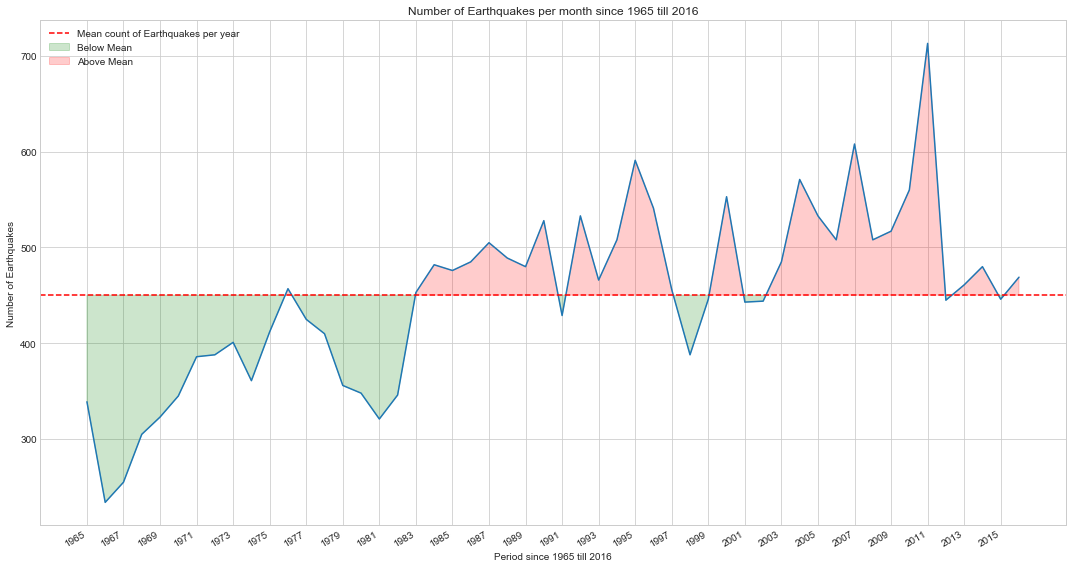

In [67]:
# Plot the line graph for the number of earthquakes per month
figure = plt.figure(figsize=(15,8))
plt.plot(Year, annualData["size"])
plt.xlabel("Period since 1965 till 2016")
plt.ylabel("Number of Earthquakes")
plt.grid(b=True, which='major', axis='both')
plt.xticks(ticks = np.arange(0,annualData.shape[0],2), labels = xlabels)
plt.title("Number of Earthquakes per month since 1965 till 2016")
plt.tight_layout()
plt.axhline(y = np.mean(annualData["size"]), linestyle="dashed", 
           color="red",label="Mean count of Earthquakes per year")
plt.fill_between(Year, annualData["size"], np.mean(annualData["size"]),
                 where=(annualData["size"] <= np.mean(annualData["size"])), interpolate = True,
                 color = "green", alpha = 0.2, label = "Below Mean")
plt.fill_between(Year, annualData["size"], np.mean(annualData["size"]),
                 where=(annualData["size"] > np.mean(annualData["size"])), interpolate = True,
                 color = "red", alpha = 0.2, label = "Above Mean")                 
plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

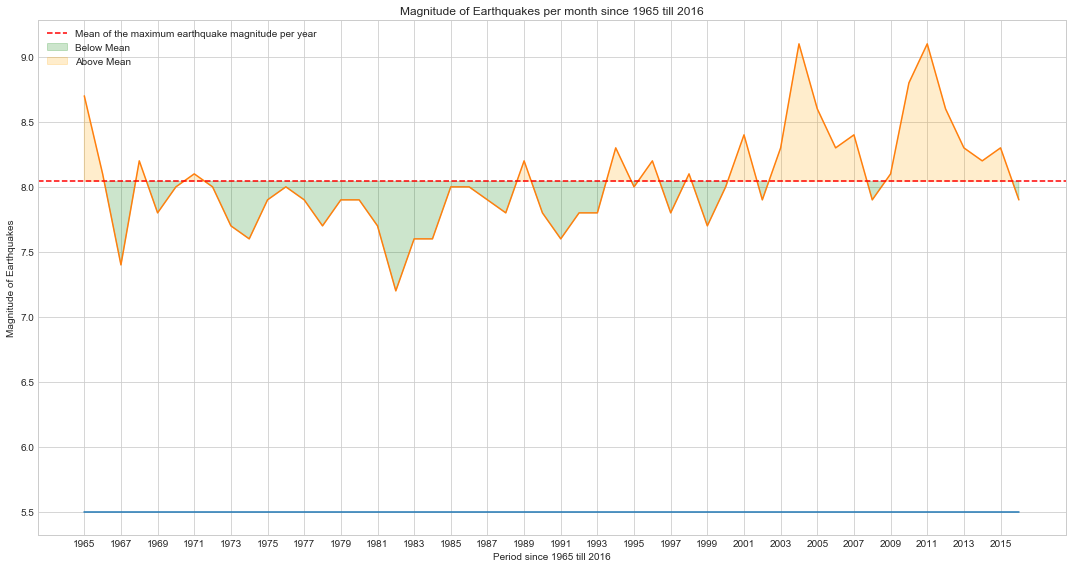

In [68]:
# Plot the line graph for the minimum and maximum magnitude per month
figure = plt.figure(figsize=(15,8))
plt.plot(Year, annualData["min"])
plt.plot(Year, annualData["max"])
plt.xlabel("Period since 1965 till 2016")
plt.ylabel("Magnitude of Earthquakes")
plt.xticks(ticks = np.arange(0,annualData.shape[0],2), labels = xlabels)
plt.grid(b=True, which='major', axis='both')
plt.axhline(y = np.mean(annualData["max"]), linestyle="dashed", 
           color="red",label="Mean of the maximum earthquake magnitude per year")
plt.fill_between(Year, annualData["max"], np.mean(annualData["max"]),
                 where=(annualData["max"] <= np.mean(annualData["max"])), interpolate = True,
                 color = "green", alpha = 0.2, label = "Below Mean")
plt.fill_between(Year, annualData["max"], np.mean(annualData["max"]),
                 where=(annualData["max"] > np.mean(annualData["max"])), interpolate = True,
                 color = "orange", alpha = 0.2, label = "Above Mean") 
plt.title("Magnitude of Earthquakes per month since 1965 till 2016")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

#### INFERENCE OF DATE ANALYSIS

As evident from the line plots of annual numbers, 
1. The number of earthquakes have been on an increasing trend, especially, since 1999, it has been primarily over the mean count of earthquakes per year since 1965.
2. The highest number of earthquakes were recorded in 2011
3. Even from the maximum magnitudes recorded persepective, the highest recorded have been above 9 in 2002 and 2011.
4. Considering the minimum magnitude recorded has been only 5.5, we have seen this to be recorded every year.
5. The earthquakes since 2000, again have been more powerful and have been primarily above the mean earthquake recorded over the years.

In [69]:
print ("INFERENCE OF DATE ANALYSIS")
print ("--------------------------")
print ("")
print ("As evident from the line plots of annual numbers,")
print ("\t 1. The number of earthquakes have been on an increasing trend, especially, since 1999, it has been primarily over the mean count of earthquakes per year since 1965.")
print ("\t 2. The highest number of earthquakes were recorded in 2011.")
print ("\t 3. Even from the maximum magnitudes recorded persepective, the highest recorded have been above 9 in 2002 and 2011.")
print ("\t 4. Considering the minimum magnitude recorded has been only 5.5, we have seen this to be recorded every year.")
print ("\t 5. The earthquakes since 2000, again have been more powerful and have been primarily above the mean earthquake recorded over the years.")

INFERENCE OF DATE ANALYSIS
--------------------------

As evident from the line plots of annual numbers,
	 1. The number of earthquakes have been on an increasing trend, especially, since 1999, it has been primarily over the mean count of earthquakes per year since 1965.
	 2. The highest number of earthquakes were recorded in 2011.
	 3. Even from the maximum magnitudes recorded persepective, the highest recorded have been above 9 in 2002 and 2011.
	 4. Considering the minimum magnitude recorded has been only 5.5, we have seen this to be recorded every year.
	 5. The earthquakes since 2000, again have been more powerful and have been primarily above the mean earthquake recorded over the years.


### G. IDENTIFYING THE EARTHQUAKE BELT

Let us plot a histogram of the Longitude to understand if there are specific longitudes, which are more prone to earthquakes

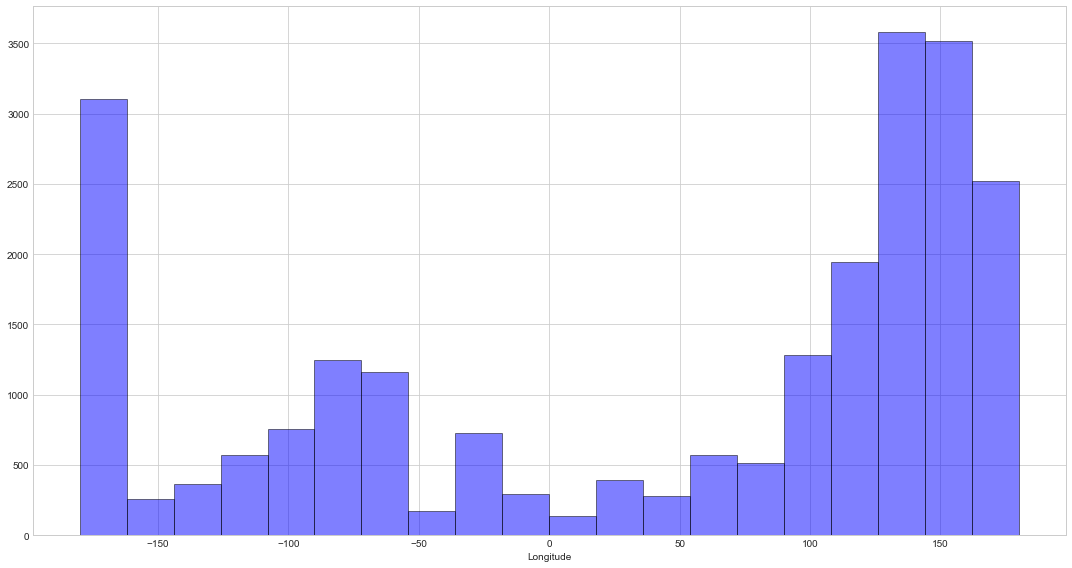

In [70]:
figure = plt.figure(figsize=(15,8))
plt.hist(quakeData['Longitude'], color = 'b', bins = 20, edgecolor = "black", alpha = 0.5)
plt.xlabel('Longitude')
plt.tight_layout()
plt.show()

Now let us try to plot a histogram of the Latitudes to understand if specific Latitudes are more earthquake prone.

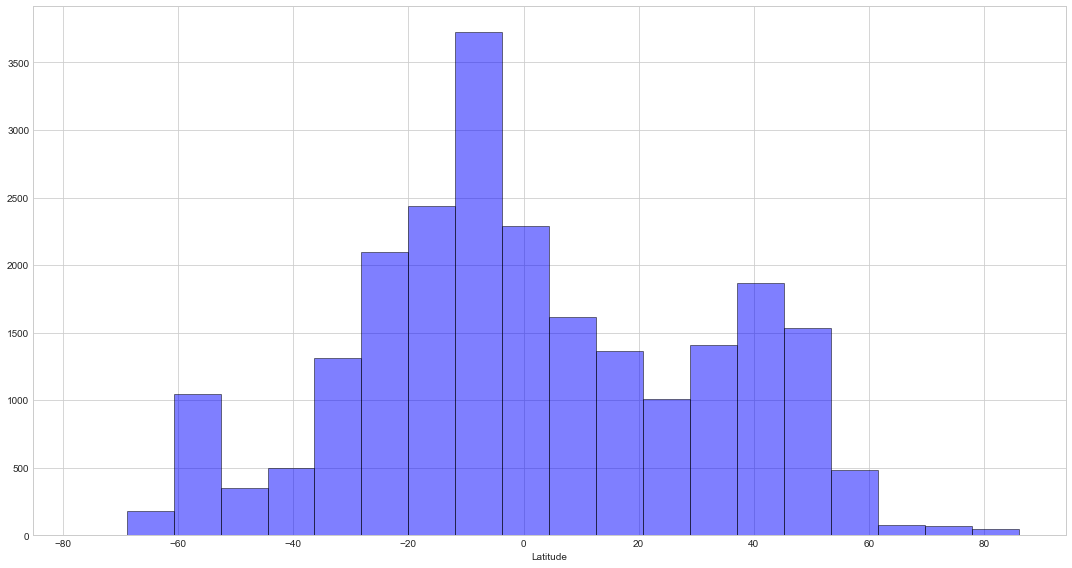

In [71]:
figure = plt.figure(figsize=(15,8))
plt.hist(quakeData['Latitude'], color = 'b', bins = 20, edgecolor = "black", alpha = 0.5)
plt.xlabel('Latitude')
plt.tight_layout()
plt.show()

Let us try to plot the longitude vs latitude to understand if there are any specific fault lines

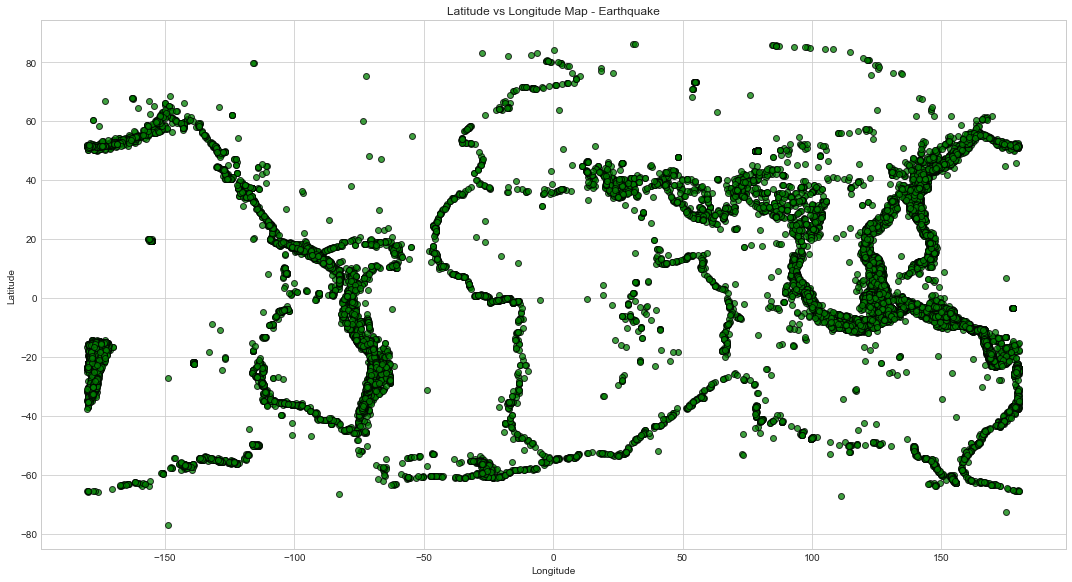

In [72]:
figure = plt.figure(figsize=(15,8))
plt.scatter(quakeData["Longitude"], quakeData["Latitude"], alpha = 0.75, color = "green", edgecolor = "black")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.tight_layout()
plt.title("Latitude vs Longitude Map - Earthquake")
plt.show()

As evident from the above plot, there are specific longitudes and latitude ranges, where we have a lot of earthquakes. To understand this better from the geographical map perspective, let us plot it in on the world map.

C:\Users\rayde\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


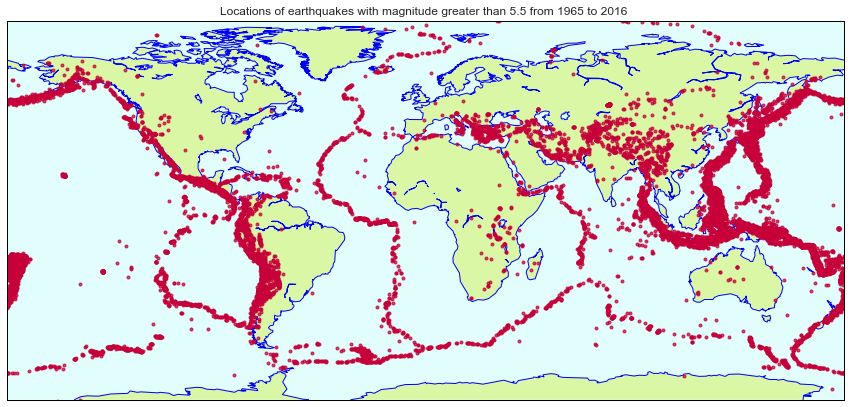

In [73]:
figure = plt.figure(figsize=(15,8))
map = Basemap(projection = "cyl", llcrnrlat=np.min(quakeData["Latitude"]), llcrnrlon=np.min(quakeData["Longitude"]),
              urcrnrlat=np.max(quakeData["Latitude"]), urcrnrlon=np.max(quakeData["Longitude"]))
map.drawmapboundary(fill_color='#E1FDFC')
#Fill the continents with the land color
map.fillcontinents(color='#DAF7A6',lake_color='#E1FDFC')
map.drawcoastlines(color = "blue")

#PLot the geographical locations of the earthquake
for rows in np.arange(1,len(quakeData),1):
   x, y = map(quakeData["Longitude"][rows],quakeData["Latitude"][rows])
   map.plot(x, y, marker='.',color='#C70039', alpha = 0.75)
plt.title("Locations of earthquakes with magnitude greater than 5.5 from 1965 to 2016 ")
plt.show()

#### INFERENCE OF IDENTIFYING THE EARTHQUAKE BELT

From the above geographical map, it is clear that there are few fault lines, where repeated earthquakes strike. These are around:
1. West coast of North and South America
2. Himalayan Region, western coast of South Asia
3. Eastern coast of Asia and Australasia

In [74]:
print ("INFERENCE OF IDENTIFYING THE EARTHQUAKE BELT")
print ("-------------------------------------------")
print ("")
print ("From the above geographical map, it is clear that there are few fault lines, where repeated earthquakes strike. These are around:")
print ("\t 1. West coast of North and South America")
print ("\t 2. Himalayan Region, western coast of South Asia.")
print ("\t 3. Eastern coast of Asia and Australasia.")

INFERENCE OF IDENTIFYING THE EARTHQUAKE BELT
-------------------------------------------

From the above geographical map, it is clear that there are few fault lines, where repeated earthquakes strike. These are around:
	 1. West coast of North and South America
	 2. Himalayan Region, western coast of South Asia.
	 3. Eastern coast of Asia and Australasia.


### H. IDENTIFYING THE EARTHQUAKE BELT BY MAGNITUDE

Now let us try to plot the magnitude of the earthquakes on the world map, for earthquakes with magnitude greater than 6

C:\Users\rayde\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """
C:\Users\rayde\anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


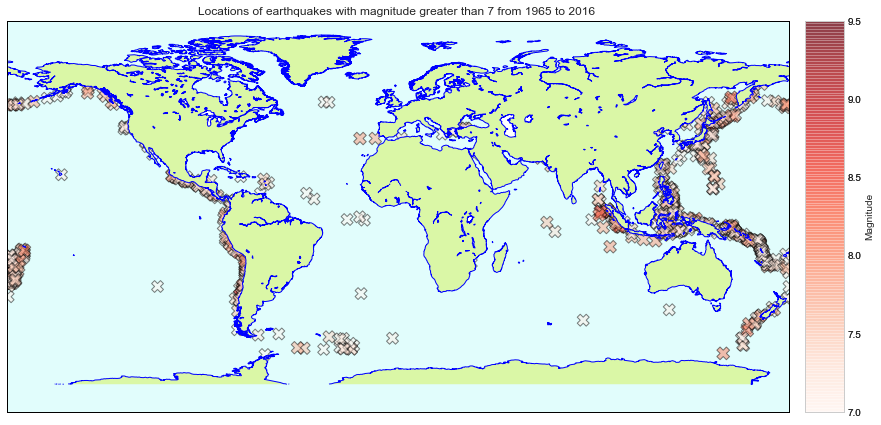

In [87]:
figure = plt.figure(figsize=(15,8))
filtrdQuake = quakeData[quakeData['Magnitude'] >= 7]
map = Basemap(projection = "cyl", llcrnrlat=np.min(quakeData["Latitude"]), llcrnrlon=np.min(quakeData["Longitude"]),
              urcrnrlat=np.max(quakeData["Latitude"]), urcrnrlon=np.max(quakeData["Longitude"]), 
              resolution = "l")
map.fillcontinents(color='#DAF7A6')
map.drawcoastlines(color = "blue")
map.drawmapboundary(fill_color='#E1FDFC')

worldmap = Basemap()

# Create the longitude-Latitude combination
x_location, y_location = worldmap(filtrdQuake["Longitude"],filtrdQuake["Latitude"])

# Plot the locations
locations = worldmap.scatter(x_location, y_location, marker='X',c=filtrdQuake["Magnitude"], alpha = 0.5,edgecolor = "black",
                             vmin = 7, vmax = 9.5, cmap = plt.get_cmap('Reds'), s=filtrdQuake["Magnitude"]*20)
map.colorbar(locations)

# Add a colorbar as legend to the right
cbar = map.colorbar(locations, location='right', label="Magnitude", shrink = 0.3)

plt.title("Locations of earthquakes with magnitude greater than 7 from 1965 to 2016 ")
plt.show()

#### INFERENCE OF IDENTIFYING THE EARTHQUAKE BELT BY MAGNITUDE

From the above geographical map, it is clear that most of the high magnitude earthquakes occur in the:
1. West coast of North and South America
2. Eastern coast of Asia and Australasia

In [81]:
print ("INFERENCE OF IDENTIFYING THE EARTHQUAKE BELT BY MAGNITUDE")
print ("---------------------------------------------------------")
print ("")
print ("From the above geographical map, it is clear that there are few fault lines, where repeated earthquakes strike. These are around:")
print ("\t 1. West coast of North and South America")
print ("\t 2. Eastern coast of Asia and Australasia")

INFERENCE OF IDENTIFYING THE EARTHQUAKE BELT BY MAGNITUDE
---------------------------------------------------------

From the above geographical map, it is clear that there are few fault lines, where repeated earthquakes strike. These are around:
	 1. West coast of North and South America
	 2. Eastern coast of Asia and Australasia


### H. BIVARIATE ANALYSIS - CORRELATION OF DATA POINTS

#### Let us try to see if there is any correlation between the different numerical data points

In [90]:
corr = quakeData.corr()
corrData = corr.style.background_gradient(cmap='coolwarm').set_precision(2)
corrData

,Latitude,Longitude,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square
Latitude,1.00,0.20,-0.08,0.02,0.18,0.03,0.00,0.11,0.05,-0.40,0.02,-0.21
Longitude,0.20,1.00,-0.09,0.05,0.00,0.04,0.00,0.04,-0.23,-0.13,-0.09,-0.03
Depth,-0.08,-0.09,1.00,0.03,0.31,0.02,0.00,-0.03,-0.17,-0.07,-0.02,-0.13
Depth Error,0.02,0.05,0.03,1.00,-0.08,-0.09,-0.00,0.00,0.25,-0.08,0.64,-0.00
Depth Seismic Stations,0.18,0.00,0.31,-0.08,1.00,0.22,0.07,-0.01,-0.39,0.03,-0.24,-0.14
Magnitude,0.03,0.04,0.02,-0.09,0.22,1.00,0.30,-0.17,-0.23,-0.09,-0.08,0.08
Magnitude Error,0.00,0.00,0.00,-0.00,0.07,0.30,1.00,-0.16,0.01,-0.05,0.40,0.04
Magnitude Seismic Stations,0.11,0.04,-0.03,0.00,-0.01,-0.17,-0.16,1.00,-0.03,-0.05,-0.04,-0.12
Azimuthal Gap,0.05,-0.23,-0.17,0.25,-0.39,-0.23,0.01,-0.03,1.00,-0.03,0.40,-0.06
Horizontal Distance,-0.40,-0.13,-0.07,-0.08,0.03,-0.09,-0.05,-0.05,-0.03,1.00,0.13,0.04


### I. BIVARIATE ANALYSIS - DEPTH ERROR VS HORIZONTAL ERROR

From the above heatmap, it shows there might be a correlation between Horizontal Error and Depth Error. So let us plot a scatterplot to try finding if there is any relation.

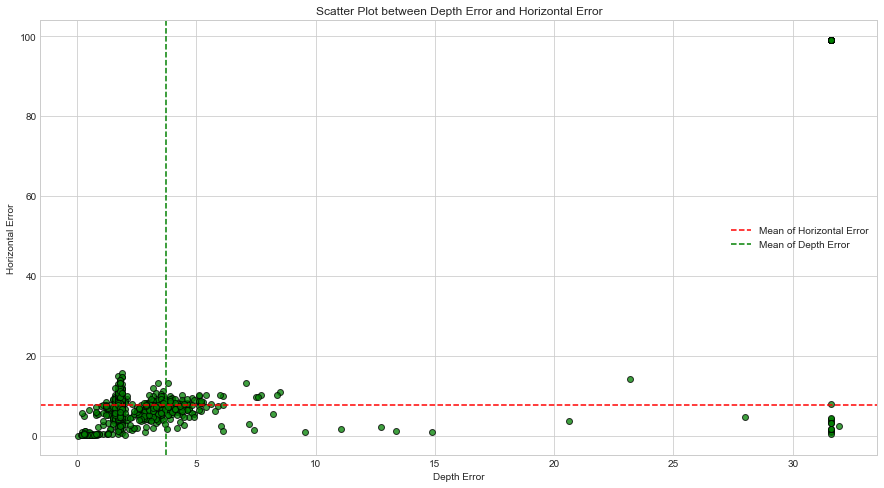

In [91]:
figure = plt.figure(figsize=(15,8))
plt.scatter(x = quakeData['Depth Error'], y = quakeData['Horizontal Error'], alpha = 0.75, color = "green", edgecolor = "black")
plt.axhline(y = np.mean(quakeData['Horizontal Error']), color = "red", 
           linestyle = "dashed", label="Mean of Horizontal Error")
plt.axvline(x = np.mean(quakeData['Depth Error']), color = "green", 
           linestyle = "dashed", label="Mean of Depth Error")
plt.xlabel("Depth Error")
plt.ylabel("Horizontal Error")
plt.legend()
plt.title("Scatter Plot between Depth Error and Horizontal Error")
plt.show()

There are **clearly some outliers** both for the Depth Error and Horizontal Error, **which might have resulted in higher correlation** between these observations. Hence, let us try to eliminate the outliers to see if there is any correlation.

In [92]:
filtrdQuake = quakeData[quakeData['Horizontal Error'].notna()]
filtrdQuake = filtrdQuake[filtrdQuake['Depth Error'] <= np.percentile(filtrdQuake['Depth Error'],90)]

newCorr = np.corrcoef(filtrdQuake['Depth Error'],  filtrdQuake['Horizontal Error'])
print(newCorr)

[[1.         0.22403171]
 [0.22403171 1.        ]]


As evident from the above details, after eliminating the outliers, the **correlation coefficient between 'Depth Error' and 'Horizontal Error' reduces to 0.22**. Thus, there is not a very significant relation between these datapoints.

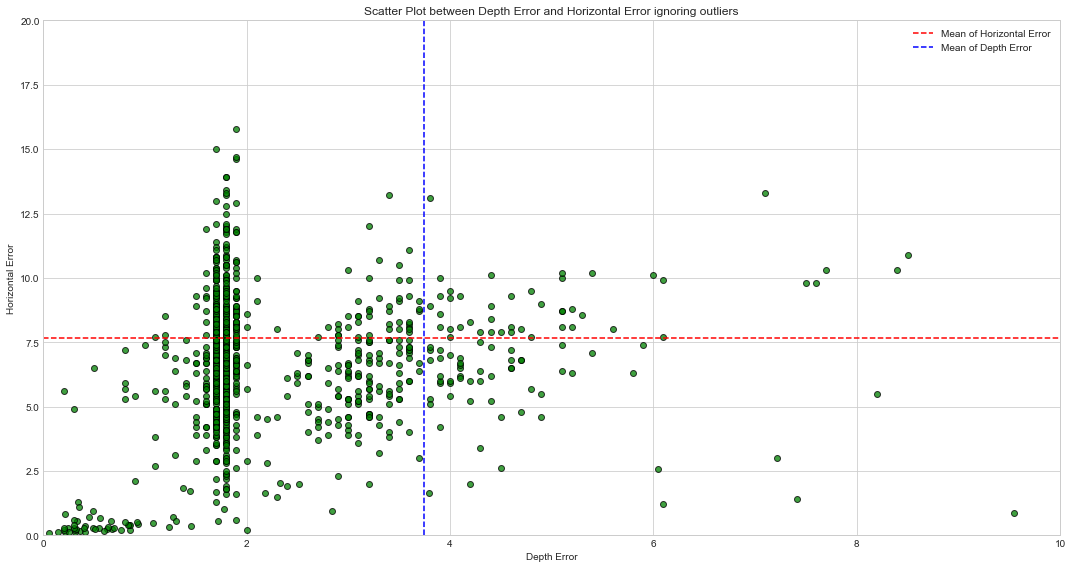

In [93]:
figure = plt.figure(figsize=(15,8))
plt.scatter(x = quakeData['Depth Error'], y = quakeData['Horizontal Error'], alpha = 0.75, color = "green", edgecolor = "black")
plt.xlabel("Depth Error")
plt.ylabel("Horizontal Error")
plt.xlim(0,10)
plt.ylim(0,20)
plt.axhline(y = np.mean(quakeData['Horizontal Error']), color = "red", 
           linestyle = "dashed", label="Mean of Horizontal Error")
plt.axvline(x = np.mean(quakeData['Depth Error']),color = "blue", 
           linestyle = "dashed", label="Mean of Depth Error")
plt.title("Scatter Plot between Depth Error and Horizontal Error ignoring outliers")
plt.legend()
plt.tight_layout()
plt.show()

####  INFERENCE OF BIVARIATE ANALYSIS - DEPTH ERROR VS HORIZONTAL ERROR

Though initially, the correlation coefficient did show a high correlation between the two variables, on ignoring the outliers, it became evident that the two variables do not have a very clear relation.

In [94]:
print ("INFERENCE OF BIVARIATE ANALYSIS - DEPTH ERROR VS HORIZONTAL ERROR")
print ("-----------------------------------------------------------------")
print ("")
print ("Though initially, the correlation coefficient did show a high correlation between the two variables, on ignoring the outliers, it became evident that the two variables do not have a very clear relation.")

INFERENCE OF BIVARIATE ANALYSIS - DEPTH ERROR VS HORIZONTAL ERROR
-----------------------------------------------------------------

Though initially, the correlation coefficient did show a high correlation between the two variables, on ignoring the outliers, it became evident that the two variables do not have a very clear relation.


### J. BIVARIATE ANALYSIS - OTHER VARIABLES

#### J.1 BIVARIATE ANALYSIS - DEPTH VS MAGNITUDE

Now, let us try to analyze if there is any relation between depth and magnitude.

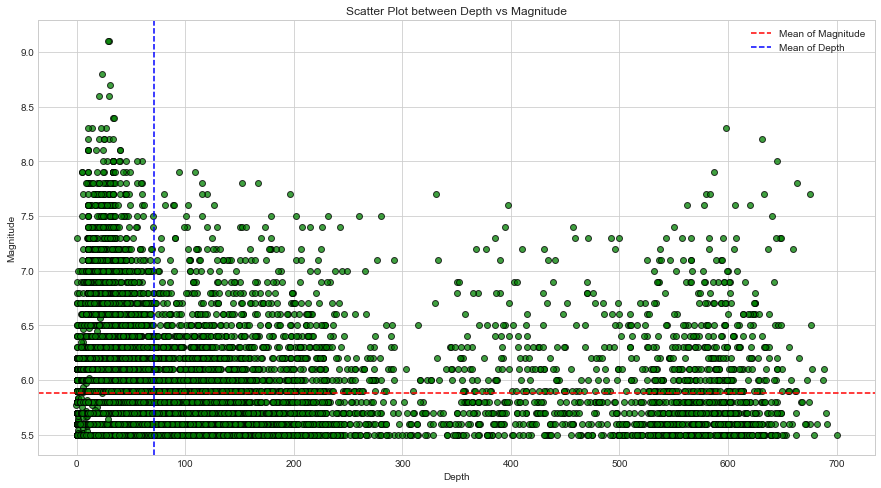

In [95]:
# Let us try to plot a scatter plot between depth and magnitude
figure = plt.figure(figsize=(15,8))
plt.scatter( quakeData['Depth'], quakeData['Magnitude'], alpha = 0.75, color = "green", edgecolor = "black")
plt.xlabel("Depth")
plt.ylabel("Magnitude")
plt.axhline(y = np.mean(quakeData['Magnitude']), color = "red", 
           linestyle = "dashed", label="Mean of Magnitude")
plt.axvline(x = np.mean(quakeData['Depth']), color = "blue", 
           linestyle = "dashed", label="Mean of Depth")
plt.title("Scatter Plot between Depth vs Magnitude")
plt.legend()
plt.show()

#### INFERENCE OF BIVARIATE ANALYSIS - DEPTH VS MAGNITUDE

As evident from the plot above, the lower magnitude earthquakes have been recorded across various depths. However, there is no strict relationship evident from this plot.

In [96]:
print ("INFERENCE OF BIVARIATE ANALYSIS - DEPTH VS MAGNITUDE")
print ("----------------------------------------------------")
print ("")
print ("As evident from the plot above, the lower magnitude earthquakes have been recorded across various depths. However, there is no strict relationship evident from this plot.")

INFERENCE OF BIVARIATE ANALYSIS - DEPTH VS MAGNITUDE
----------------------------------------------------

As evident from the plot above, the lower magnitude earthquakes have been recorded across various depths. However, there is no strict relationship evident from this plot.


#### J.2 BIVARIATE ANALYSIS - DEPTH VS DEPTH ERROR

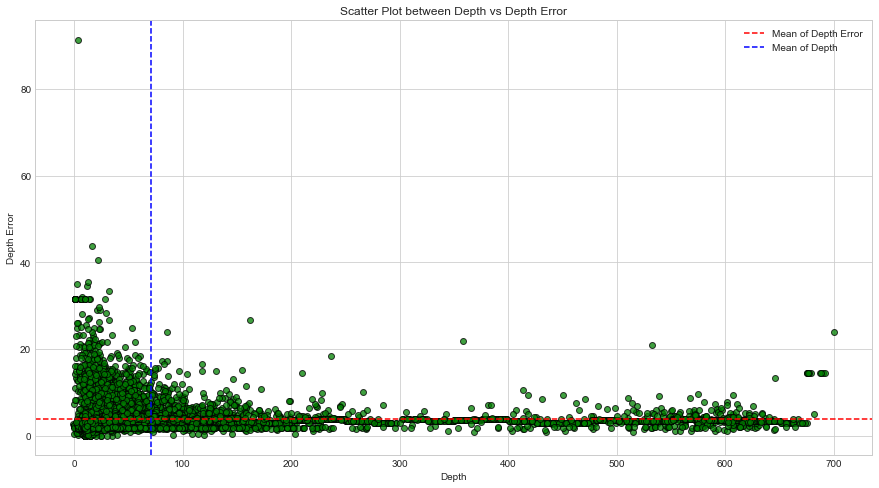

In [97]:
# Let us try to plot a scatter plot between depth and depth error
figure = plt.figure(figsize=(15,8))
plt.scatter( quakeData['Depth'], quakeData['Depth Error'], alpha = 0.75, color = "green", edgecolor = "black")
plt.xlabel("Depth")
plt.ylabel("Depth Error")
plt.axhline(y = np.mean(quakeData['Depth Error']), color = "red", 
           linestyle = "dashed", label="Mean of Depth Error")
plt.axvline(x = np.mean(quakeData['Depth']), color = "blue", 
           linestyle = "dashed", label="Mean of Depth")
plt.title("Scatter Plot between Depth vs Depth Error")
plt.legend()
plt.show()

#### INFERENCE OF BIVARIATE ANALYSIS - DEPTH VS DEPTH ERROR

As evident from the plot above, there is no clear relationship evident from this plot.

In [99]:
print ("INFERENCE OF BIVARIATE ANALYSIS - DEPTH VS DEPTH ERROR")
print ("------------------------------------------------------")
print ("")
print ("As evident from the plot above, there is no clear relationship evident from this plot.")

INFERENCE OF BIVARIATE ANALYSIS - DEPTH VS DEPTH ERROR
------------------------------------------------------

As evident from the plot above, there is no clear relationship evident from this plot.


#### J.3 BIVARIATE ANALYSIS - MAGNITUDE VS MAGNITUDE ERROR

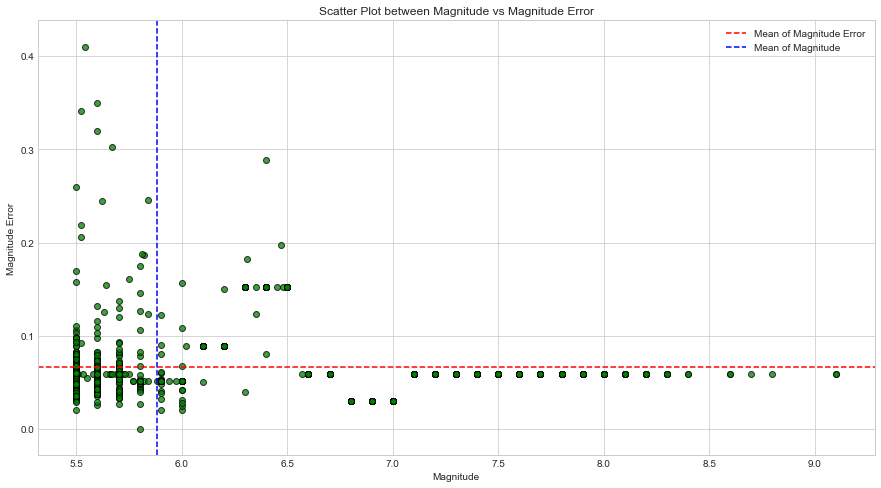

In [100]:
# Let us try to plot a scatter plot between depth and magnitude
figure = plt.figure(figsize=(15,8))
plt.scatter( quakeData['Magnitude'], quakeData['Magnitude Error'], alpha = 0.75, color = "green", edgecolor = "black")
plt.xlabel("Magnitude")
plt.ylabel("Magnitude Error")
plt.axhline(y = np.mean(quakeData['Magnitude Error']), color = "red", 
           linestyle = "dashed", label="Mean of Magnitude Error")
plt.axvline(x = np.mean(quakeData['Magnitude']), color = "blue", 
           linestyle = "dashed", label="Mean of Magnitude")
plt.title("Scatter Plot between Magnitude vs Magnitude Error")
plt.legend()
plt.show()

#### INFERENCE OF BIVARIATE ANALYSIS - MAGNITUDE VS MAGNITUDE ERROR

Again as evident from the plot above, there is no clear relationship evident from this plot.

In [101]:
print ("INFERENCE OF BIVARIATE ANALYSIS - MAGNITUDE VS MAGNITUDE ERROR")
print ("--------------------------------------------------------------")
print ("")
print ("Again as evident from the plot above, there is no clear relationship evident from this plot.")

INFERENCE OF BIVARIATE ANALYSIS - MAGNITUDE VS MAGNITUDE ERROR
--------------------------------------------------------------

Again as evident from the plot above, there is no clear relationship evident from this plot.


#### J.4 BIVARIATE ANALYSIS - DEPTH ERROR VS MAGNITUDE ERROR

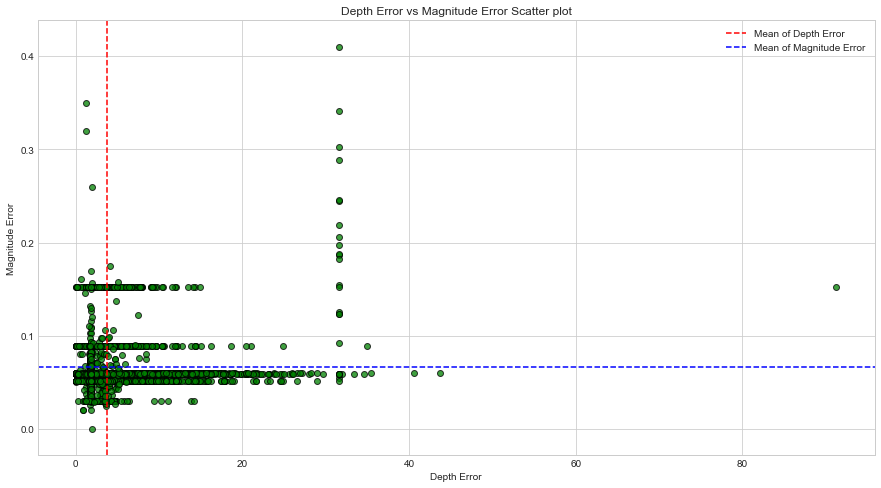

In [106]:
#Let us try to plot a scatter plot between depth and depth error
figure = plt.figure(figsize=(15,8))
plt.scatter(quakeData['Depth Error'], quakeData['Magnitude Error'], alpha = 0.75, color = "green", edgecolor = "black")
plt.axvline(x = np.mean(quakeData['Depth Error']), color = "red", 
           linestyle = "dashed", label="Mean of Depth Error")
plt.axhline(y = np.mean(quakeData['Magnitude Error']), color = "blue", 
           linestyle = "dashed", label="Mean of Magnitude Error")
plt.ylabel("Magnitude Error")
plt.xlabel("Depth Error")
plt.title("Depth Error vs Magnitude Error Scatter plot")
plt.legend()
plt.show()

#### INFERENCE OF BIVARIATE ANALYSIS - DEPTH ERROR VS MAGNITUDE ERROR

Here too, there are no speific relationships evident from the plot.

In [107]:
print ("INFERENCE OF BIVARIATE ANALYSIS - DEPTH ERROR VS MAGNITUDE ERROR")
print ("-----------------------------------------------------------------")
print ("")
print ("Here too, there are no speific relationships evident from the plot.")

INFERENCE OF BIVARIATE ANALYSIS - DEPTH ERROR VS MAGNITUDE ERROR
-----------------------------------------------------------------

Here too, there are no speific relationships evident from the plot.


### FINAL INFERENCE

1. There are some specific belts like (Ring of Fire), which are more prone to earthquakes as per the historical data.
2. Both from the perspective of total numbers and maximum magnitude, the numbers have increased since 2000.
3. There are no specific relationships evident between any other variables noticed.

In [108]:
print ("FINAL INFERENCE")
print ("---------------")
print ("")
print ("\t 1. There are some specific belts like (Ring of Fire), which are more prone to earthquakes as per the historical data.")
print ("\t 2. Both from the perspective of total numbers and maximum magnitude, the numbers have increased since 2000.")
print ("\t 3. There are no specific relationships evident between any other variables noticed.")

FINAL INFERENCE
---------------

	 1. There are some specific belts like (Ring of Fire), which are more prone to earthquakes as per the historical data.
	 2. Both from the perspective of total numbers and maximum magnitude, the numbers have increased since 2000.
	 3. There are no specific relationships evident between any other variables noticed.
